In [ ]:
pip install moviepy==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.0 MB/s eta 0:00:00


In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2023-02-08 13:59:03--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  75.6MB/s    in 47s     

2023-02-08 13:59:51 (65.2 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



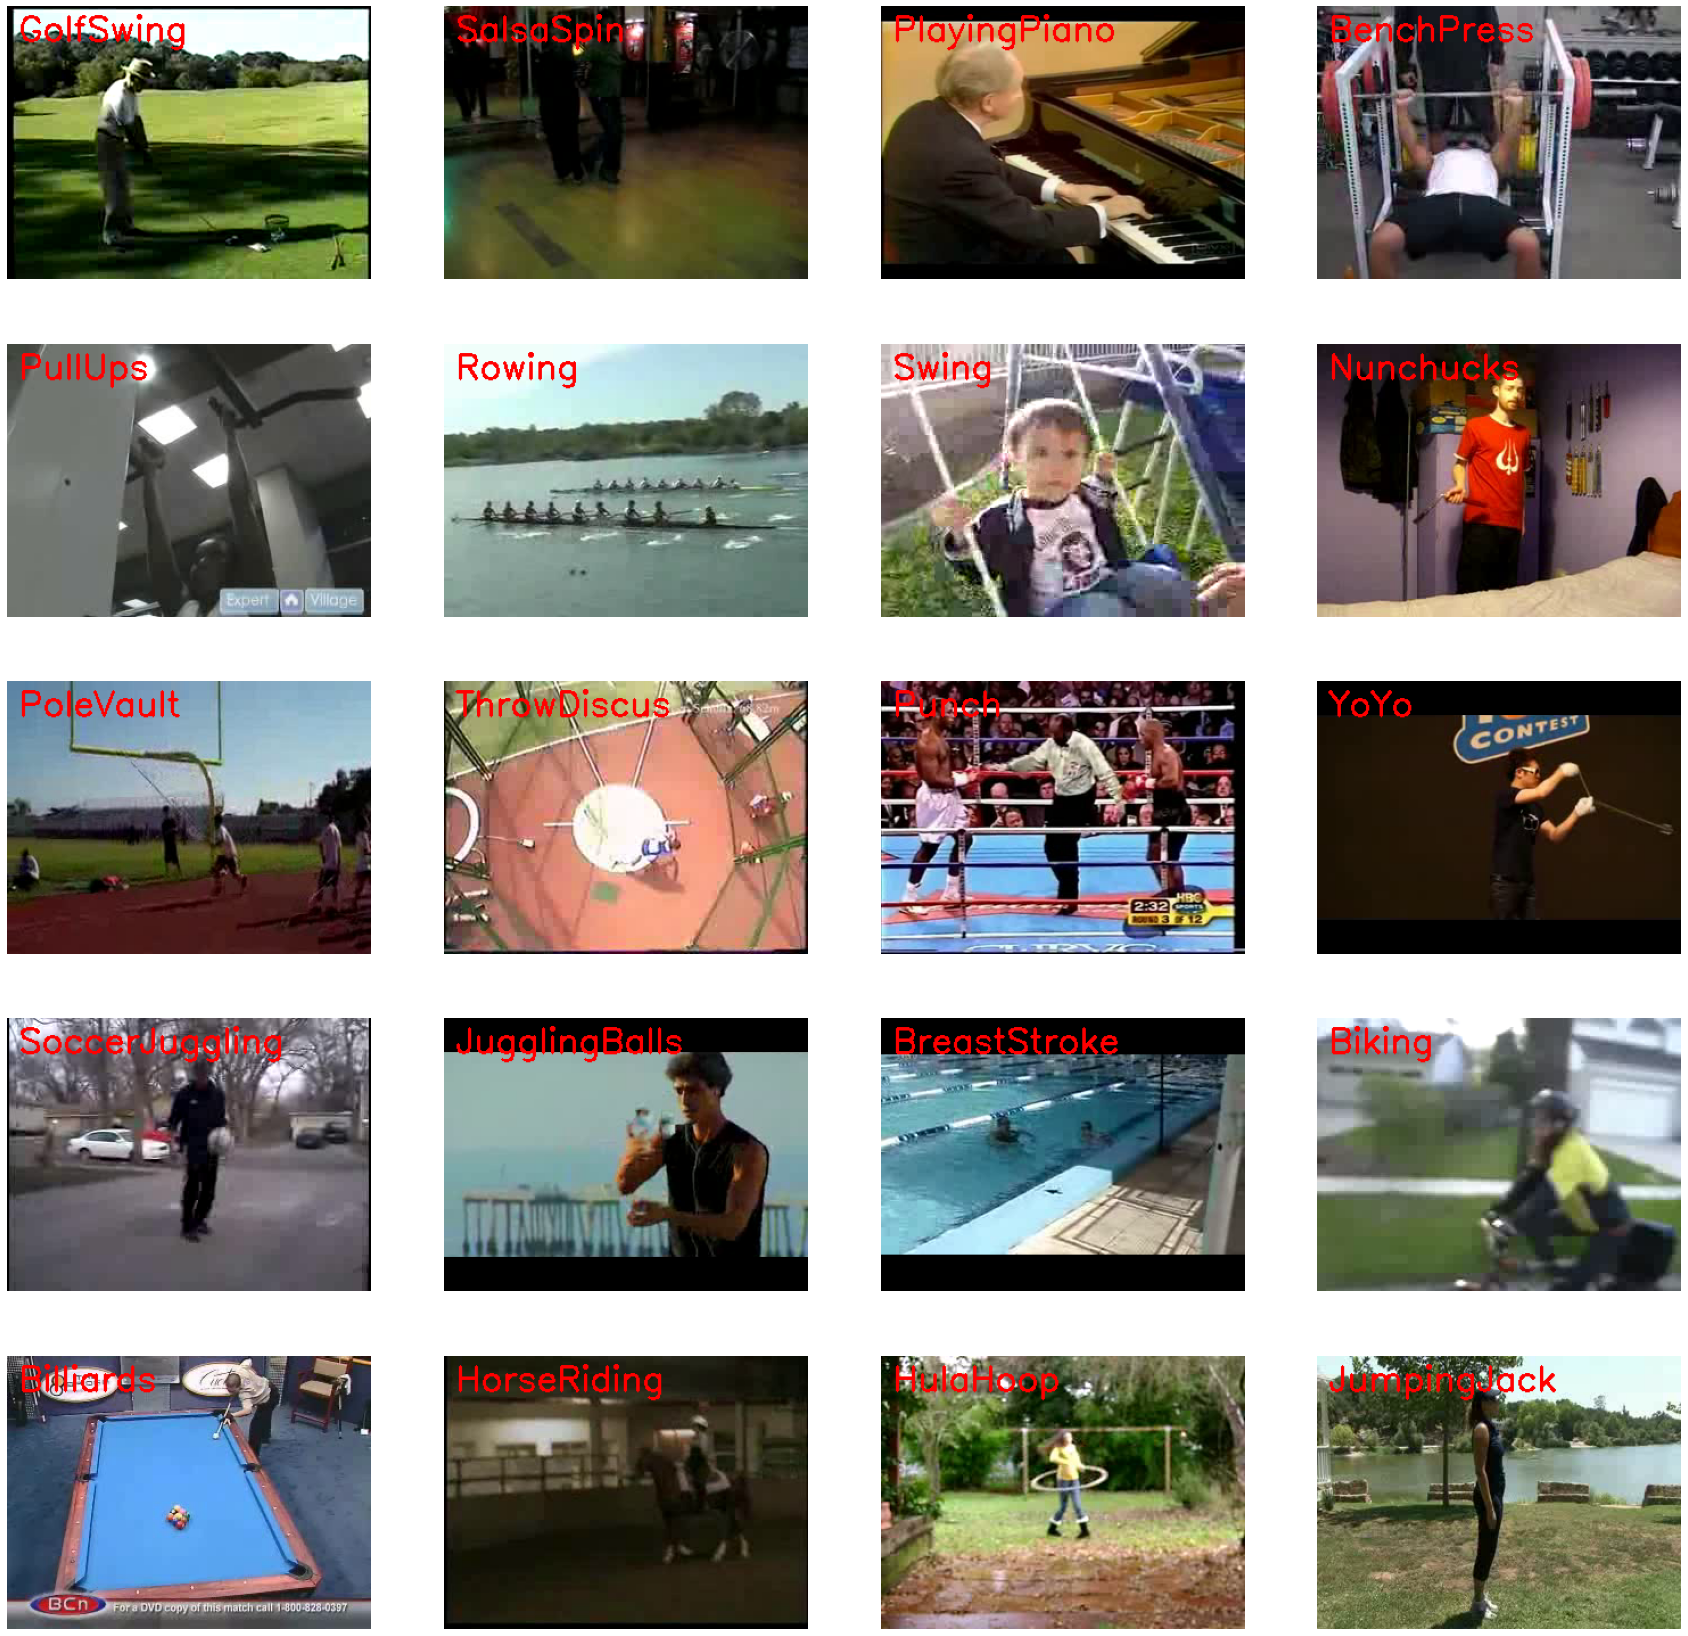

In [ ]:
plt.figure(figsize = (30, 30))
 
all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
 
    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()
 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 8000
 
dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]
 
model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    while True:
 
        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        normalized_frame = resized_frame / 255
         
        frames_list.append(normalized_frame)
     
    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():
 
    temp_features = [] 
    features = []
    labels = []
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
         
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
 
        for file_name in files_list:
 
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
 
            frames = frames_extraction(video_file_path)

            temp_features.extend(frames)
         
        features.extend(random.sample(temp_features, max_images_per_class))

        labels.extend([class_index] * max_images_per_class)
        temp_features.clear()

    features = np.asarray(features)
    labels = np.array(labels)  
 
    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = 23)


In [ ]:
def create_model():
 
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
    model.summary()
 
    return model
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True) 
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/10
5120/5120 [==============================] - 745s 145ms/step - loss: 0.8444 - accuracy: 0.6645 - val_loss: 0.4817 - val_accuracy: 0.8148
Epoch 2/10
5120/5120 [==============================] - 741s 145ms/step - loss: 0.4799 - accuracy: 0.8282 - val_loss: 0.1661 - val_accuracy: 0.9469
Epoch 3/10
5120/5120 [==============================] - 749s 146ms/step - loss: 0.3476 - accuracy: 0.8782 - val_loss: 0.2602 - val_accuracy: 0.9014
Epoch 4/10
5120/5120 [==============================] - 758s 148ms/step - loss: 0.2818 - accuracy: 0.9039 - val_loss: 0.5623 - val_accuracy: 0.8711
Epoch 5/10
5120/5120 [==============================] - 760s 148ms/step - loss: 0.2492 - accuracy: 0.9169 - val_loss: 0.5379 - val_accuracy: 0.8439
Epoch 6/10
5120/5120 [==============================] - 752s 147ms/step - loss: 0.2369 - accuracy: 0.9213 - val_loss: 0.1077 - val_accuracy: 0.9615
Epoch 7/10
5120/5120 [==============================] - 744s 145ms/step - loss: 0.2138 - accuracy: 0.9309 - val_

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 49s 240ms/step - loss: 0.1630 - accuracy: 0.9497


In [ ]:
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Saving your Model
model.save(model_name)